## Data augmentation

### Oversampling
- SMOTE-NC

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import torch

import warnings
warnings.filterwarnings("ignore") 

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [3]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017.csv"
data = pd.read_csv(data_path, low_memory=False)

### Data Preprocessing

In [4]:
data['loan_status'].value_counts()

loan_status
0    1207257
1     287765
Name: count, dtype: int64

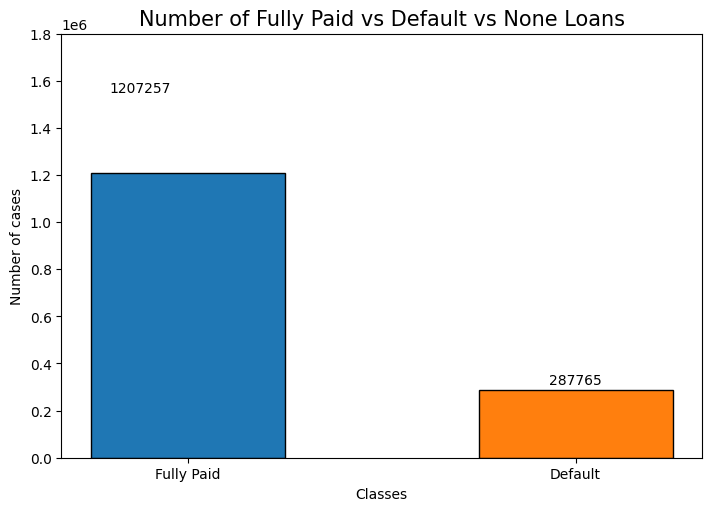

In [5]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [6]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 4.195287821660035


In [7]:
print(f"The number of features : {len(data.columns)}\nThe target feature : {data[['loan_status']].columns}")

The number of features : 66
The target feature : Index(['loan_status'], dtype='object')


### Base Modeling 

In [92]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017.csv"
test_data = pd.read_csv(test_data_path)

In [98]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495022 entries, 0 to 1495021
Data columns (total 65 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1495022 non-null  float64
 1   funded_amnt                 1495022 non-null  float64
 2   funded_amnt_inv             1495022 non-null  float64
 3   term                        1495022 non-null  object 
 4   int_rate                    1495022 non-null  float64
 5   installment                 1495022 non-null  float64
 6   grade                       1495022 non-null  object 
 7   sub_grade                   1495022 non-null  object 
 8   home_ownership              1495022 non-null  object 
 9   annual_inc                  1495022 non-null  float64
 10  verification_status         1495022 non-null  object 
 11  zip_code                    1495022 non-null  float64
 12  addr_state                  1495022 non-null  object 
 1

In [99]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

Encoded data_x sample:
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     0     10.99       392.81   
1     4800.0       4800.0           4800.0     0     10.99       157.13   
2    27050.0      27050.0          27050.0     0     10.99       885.46   
3    12000.0      12000.0          12000.0     0      7.62       373.94   
4    14000.0      14000.0          14000.0     0     12.85       470.71   

   grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
0      1          6               5     60000.0  ...           100.0   
1      1          6               1     39600.0  ...           100.0   
2      1          6               4     55000.0  ...           100.0   
3      0          2               1     96500.0  ...           100.0   
4      1          8               5     88000.0  ...            78.6   

   percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  \
0               0.0

In [101]:
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1196017 samples (80.0%)
Validation size: 299005 samples (20.0%)
Test size: 266107 samples (17.8%)


In [102]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
1406896   0.230769     0.230769         0.235182   0.0  0.415660     0.202111   
1267104   0.128205     0.128205         0.133206   0.0  0.238411     0.112403   
661712    0.692308     0.692308         0.694073   0.0  0.035840     0.495621   
703097    0.846154     0.846154         0.847036   0.0  0.363459     0.681019   
1214333   0.064103     0.064103         0.069471   0.0  0.291001     0.065689   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
1406896  0.333333   0.411765             1.0    0.000482  ...             1.0   
1267104  0.166667   0.235294             1.0    0.000454  ...             1.0   
661712   0.000000   0.029412             0.2    0.000682  ...             1.0   
703097   0.333333   0.411765             0.2    0.001818  ...             1.0   
1214333  0.333333   0.294118             0.8    0.000582  ...             1.0   

   

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.49704	validation_1-logloss:0.49705
[1]	validation_0-logloss:0.49609	validation_1-logloss:0.49615
[2]	validation_0-logloss:0.49517	validation_1-logloss:0.49530
[3]	validation_0-logloss:0.49429	validation_1-logloss:0.49446
[4]	validation_0-logloss:0.49344	validation_1-logloss:0.49365
[5]	validation_0-logloss:0.49260	validation_1-logloss:0.49281
[6]	validation_0-logloss:0.49179	validation_1-logloss:0.49204
[7]	validation_0-logloss:0.49102	validation_1-logloss:0.49130
[8]	validation_0-logloss:0.49025	validation_1-logloss:0.49059
[9]	validation_0-logloss:0.48950	validation_1-logloss:0.48993
[10]	validation_0-logloss:0.48946	validation_1-logloss:0.48978
[11]	validation_0-logloss:0.48941	validation_1-logloss:0.48979
[12]	validation_0-logloss:0.48869	validation_1-logloss:0.48911
[13]	validation_0-logloss:0.48799	validation_1-logloss:0.48839
[14]	validation_0-logloss:0.48794	validation_1-logloss:0.48827
[15]	validation_0-logloss:0.48726	validation_1-logloss:0.48752
[1

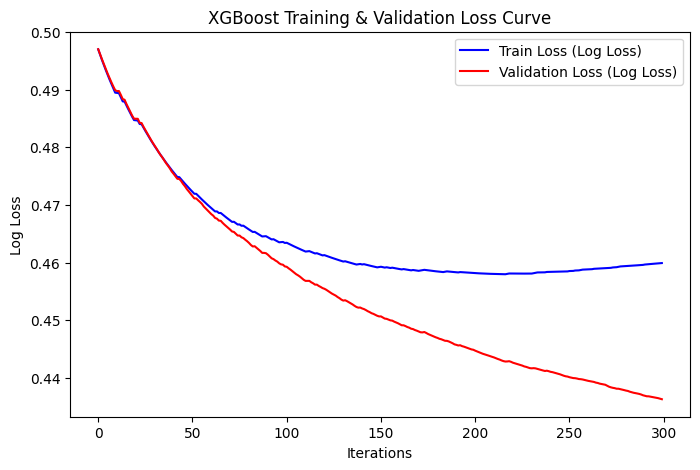

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    208044
           1       1.00      0.10      0.18     58063

    accuracy                           0.80    266107
   macro avg       0.90      0.55      0.53    266107
weighted avg       0.84      0.80      0.73    266107



In [104]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

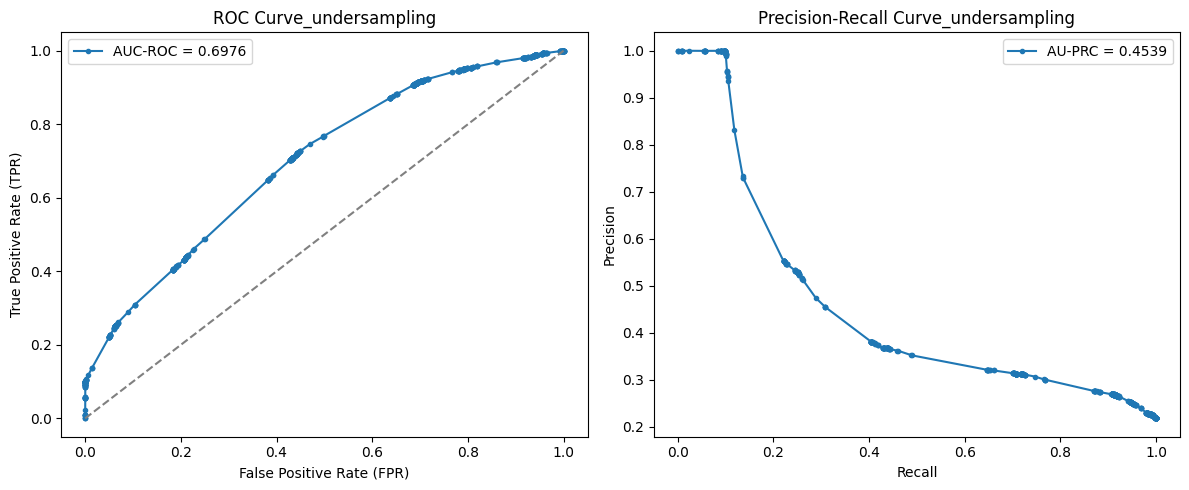

In [105]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

### Apply OverSampling 

In [17]:
"""from imblearn.over_sampling import SMOTENC

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]

smotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

print(f"SMOTE-MC data length : {len(X_train_smotenc)}")
print(f"SMOTE-MC data length : {len(y_train_smotenc)}")

print(f"\nThe number of Classes : {y_train_smotenc.value_counts()}")"""

'from imblearn.over_sampling import SMOTENC\n\ncategorical_features = X_train.select_dtypes(include=[\'object\', \'category\']).columns\ncategorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]\n\nsmotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)\nX_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)\n\nprint(f"SMOTE-MC data length : {len(X_train_smotenc)}")\nprint(f"SMOTE-MC data length : {len(y_train_smotenc)}")\n\nprint(f"\nThe number of Classes : {y_train_smotenc.value_counts()}")'

In [ ]:
"""## 증강 시간이 오래 걸리기 때문 데이터 저장을 한다.
augmentation_data = pd.concat([X_train_smotenc, y_train_smotenc], axis = 1)

address = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset"

augmentation_data.to_csv(path_or_buf=address+"smotenc_data.csv", index=False)"""

In [ ]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017.csv"
test_data = pd.read_csv(test_data_path)

In [55]:
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/smotenc_data.csv"
augmentation_data = pd.read_csv(data_path)

### Handle Missing Value for train dataset

In [67]:
# Train
print(f"Before drop Train : {augmentation_data.shape[0]} samples")
augmentation_data_cleaned = augmentation_data.dropna()
print(f"After drop Train : {len(augmentation_data_cleaned)} samples")

Before drop Train : 2414514 samples
After drop Train : 2414514 samples


In [68]:
X_train_smotenc = augmentation_data.drop(columns='loan_status')
y_train_smotenc = augmentation_data[['loan_status']]

### LabelEncoding

In [69]:
# 4️⃣ Label Encoding (Train 데이터)
label_encoders = {}

# 🔹 X_train_smotenc: 범주형(Object) 컬럼 Label Encoding
for col in X_train_smotenc.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_smotenc[col] = le.fit_transform(X_train_smotenc[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 y_train_smotenc: loan_status도 Label Encoding
le_y = LabelEncoder()
y_train_smotenc['loan_status'] = le_y.fit_transform(y_train_smotenc['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded X_train_smotenc sample:\n", X_train_smotenc.head())
print("Encoded y_train_smotenc sample:\n", y_train_smotenc.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())


Encoded X_train_smotenc sample:
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     0     10.99       392.81   
1     4800.0       4800.0           4800.0     0     10.99       157.13   
2    27050.0      27050.0          27050.0     0     10.99       885.46   
3    12000.0      12000.0          12000.0     0      7.62       373.94   
4    14000.0      14000.0          14000.0     0     12.85       470.71   

   grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
0      1          6               5     60000.0  ...           100.0   
1      1          6               1     39600.0  ...           100.0   
2      1          6               4     55000.0  ...           100.0   
3      0          2               1     96500.0  ...           100.0   
4      1          8               5     88000.0  ...            78.6   

   percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  \
0         

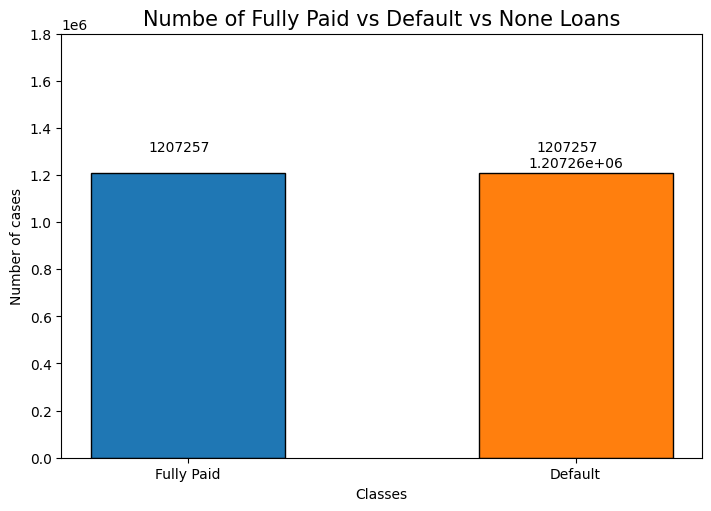

In [70]:
# Visualizing the encoded target

defalut_fully_paid = y_train_smotenc.value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.8,1300000,defalut_fully_paid[0])
ax.text(3.8,1300000,defalut_fully_paid[1])

fig.show()

In [71]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(X_train_smotenc, y_train_smotenc, test_size=0.2, random_state=42, stratify=y_train_smotenc)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(augmentation_data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(augmentation_data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(augmentation_data):.1%})")

Train size: 1931611 samples (80.0%)
Validation size: 482903 samples (20.0%)
Test size: 266107 samples (11.0%)


### Min - Max Scaling 

In [72]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
1044693   0.871795     0.871795         0.872530   0.0  0.174523     0.653764   
1060167   0.153846     0.153846         0.158700   0.0  0.240358     0.131710   
2335757   0.358974     0.358974         0.362054   0.0  0.365777     0.293218   
2015114   0.335423     0.335423         0.339235   1.0  0.690352     0.236541   
1332635   0.230769     0.230769         0.235182   0.0  0.084534     0.178489   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
1044693  0.166667   0.205882             0.2    0.002587  ...        1.000000   
1060167  0.166667   0.264706             0.8    0.001248  ...        1.000000   
2335757  0.333333   0.411765             1.0    0.001425  ...        0.993494   
2015114  0.666667   0.823529             1.0    0.001985  ...        1.000000   
1332635  0.000000   0.088235             0.8    0.002154  ...        0.900000   

   

In [64]:
"""# Encoding, Scaling 필요 변수 -> X_train, X_val,X_test
X_val.info()"""

'# Encoding, Scaling 필요 변수 -> X_train, X_val,X_test\nX_val.info()'

In [86]:
print("Train Data Shape:", X_train_scaled.shape)
print("Validation Data Shape:", X_val.shape)
print("Feature Names Match:", X_train_scaled.columns.equals(X_val.columns))

Train Data Shape: (1931611, 65)
Validation Data Shape: (482903, 65)
Feature Names Match: True


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.84125	validation_1-logloss:0.84393
[1]	validation_0-logloss:0.83772	validation_1-logloss:0.84281
[2]	validation_0-logloss:0.83517	validation_1-logloss:0.84253
[3]	validation_0-logloss:0.83128	validation_1-logloss:0.84194
[4]	validation_0-logloss:0.82747	validation_1-logloss:0.84137
[5]	validation_0-logloss:0.82410	validation_1-logloss:0.84031
[6]	validation_0-logloss:0.82061	validation_1-logloss:0.83956
[7]	validation_0-logloss:0.81699	validation_1-logloss:0.83904
[8]	validation_0-logloss:0.81377	validation_1-logloss:0.83804
[9]	validation_0-logloss:0.81063	validation_1-logloss:0.83705
[10]	validation_0-logloss:0.80732	validation_1-logloss:0.83624
[11]	validation_0-logloss:0.80427	validation_1-logloss:0.83534
[12]	validation_0-logloss:0.80134	validation_1-logloss:0.83437
[13]	validation_0-logloss:0.79841	validation_1-logloss:0.83354
[14]	validation_0-logloss:0.79522	validation_1-logloss:0.83347
[15]	validation_0-logloss:0.79300	validation_1-logloss:0.83328
[1

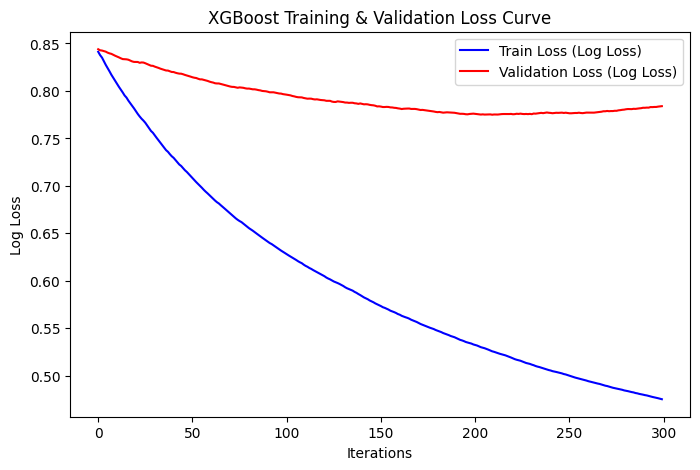

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72    208044
           1       0.15      0.19      0.16     58063

    accuracy                           0.58    266107
   macro avg       0.45      0.44      0.44    266107
weighted avg       0.62      0.58      0.60    266107



In [91]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

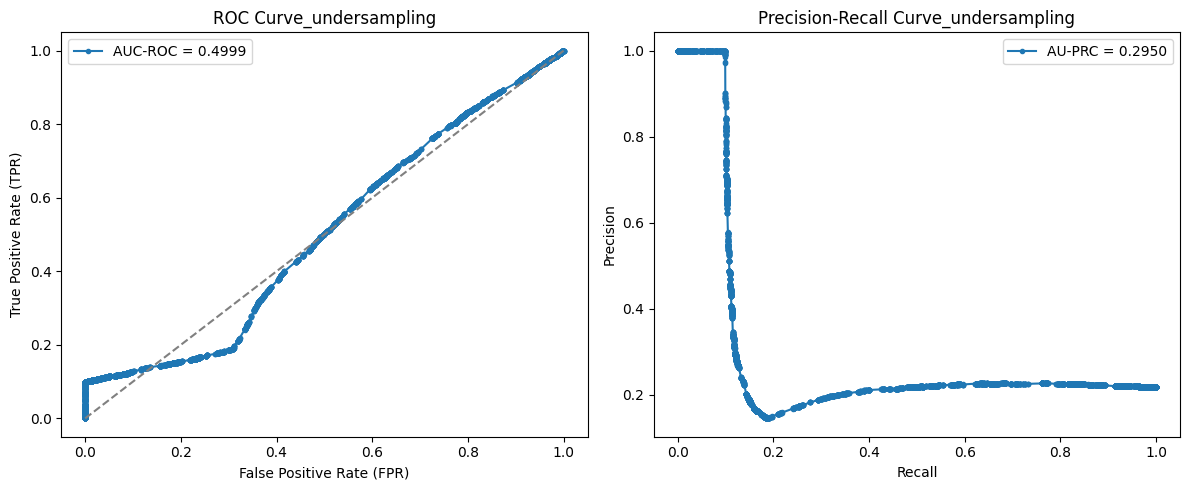

In [89]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

### tablegan modeling

In [3]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017.csv"
data = pd.read_csv(data_path, low_memory=False)

In [4]:
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)

In [5]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 65 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   900000 non-null  float64
 1   funded_amnt                 900000 non-null  float64
 2   funded_amnt_inv             900000 non-null  float64
 3   term                        900000 non-null  object 
 4   int_rate                    900000 non-null  float64
 5   installment                 900000 non-null  float64
 6   grade                       900000 non-null  object 
 7   sub_grade                   900000 non-null  object 
 8   home_ownership              900000 non-null  object 
 9   annual_inc                  900000 non-null  float64
 10  verification_status         900000 non-null  object 
 11  zip_code                    900000 non-null  float64
 12  addr_state                  900000 non-null  object 
 13  dti           

In [6]:
fake['loan_status'] = 1
fake['loan_status'].head()

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [7]:
from sklearn.utils import shuffle

train_total = pd.concat([data,fake])
train_total = shuffle(train_total, random_state=42)

In [11]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017.csv"
test_data = pd.read_csv(test_data_path)

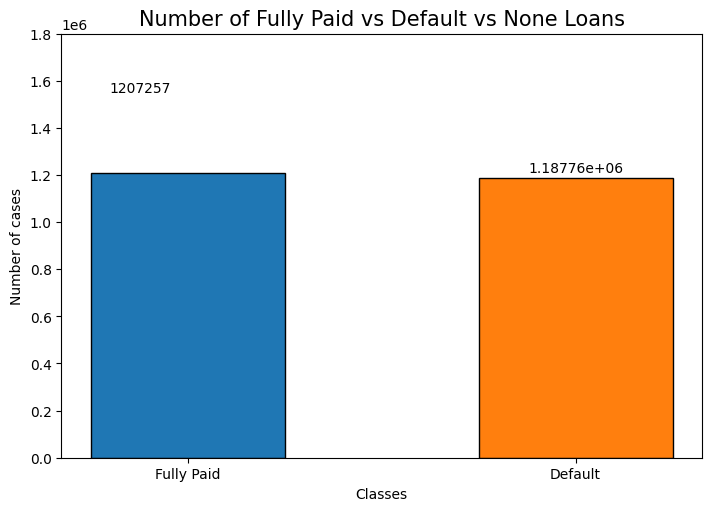

In [8]:
# Visualizing the encoded target

defalut_fully_paid = train_total['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [9]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 1.0164106536225601


In [12]:
data_x = train_total.drop(columns='loan_status')
data_y = train_total[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

### LabelEncoding

In [13]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

Encoded data_x sample:
         loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
737365     4400.0       4400.0           4400.0     0     15.61       153.85   
594041    27000.0      27000.0          27000.0     1     14.33       632.88   
93302     20400.0      20300.0          19925.0     1     13.53       644.87   
125601    21625.0      21475.0          20950.0     1     21.48       576.84   
802378     8825.0       8650.0           8700.0     1     16.90       272.62   

        grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
737365      3         15               1     39416.0  ...           100.0   
594041      2         14               4     54000.0  ...           100.0   
93302       2          9               2     51890.0  ...            99.3   
125601      4         11               2     63840.0  ...           100.0   
802378      1          3               1     18900.0  ...            71.1   

        percent_bc_gt_75  pub_re

### Train-Validation Split

In [14]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(train_total):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(train_total):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(train_total):.1%})")

Train size: 1916017 samples (80.0%)
Validation size: 479005 samples (20.0%)
Test size: 266107 samples (11.1%)


### Min-Max Scaling

In [15]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
195906    0.064103     0.064103         0.068878   0.0  0.160499     0.062447   
172351    0.158974     0.158974         0.163265   0.0  0.458512     0.147006   
271043    0.115385     0.115385         0.119898   0.0  0.000000     0.093714   
1386163   0.358974     0.358974         0.362245   1.0  0.240358     0.189451   
1315909   0.615385     0.615385         0.617347   1.0  0.142968     0.299673   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
195906   0.166667   0.147059             0.2    0.000809  ...           0.977   
172351   0.500000   0.441176             1.0    0.000682  ...           1.000   
271043   0.000000   0.000000             0.2    0.000909  ...           1.000   
1386163  0.166667   0.264706             0.2    0.000727  ...           1.000   
1315909  0.166667   0.147059             0.8    0.001200  ...           0.870   

   

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.83634	validation_1-logloss:0.83642
[1]	validation_0-logloss:0.83003	validation_1-logloss:0.83024
[2]	validation_0-logloss:0.82384	validation_1-logloss:0.82417
[3]	validation_0-logloss:0.81778	validation_1-logloss:0.81822
[4]	validation_0-logloss:0.81183	validation_1-logloss:0.81243
[5]	validation_0-logloss:0.80599	validation_1-logloss:0.80671
[6]	validation_0-logloss:0.80026	validation_1-logloss:0.80104
[7]	validation_0-logloss:0.79464	validation_1-logloss:0.79557
[8]	validation_0-logloss:0.78912	validation_1-logloss:0.79017
[9]	validation_0-logloss:0.78370	validation_1-logloss:0.78484
[10]	validation_0-logloss:0.77867	validation_1-logloss:0.77992
[11]	validation_0-logloss:0.77373	validation_1-logloss:0.77512
[12]	validation_0-logloss:0.76858	validation_1-logloss:0.77007
[13]	validation_0-logloss:0.76351	validation_1-logloss:0.76510
[14]	validation_0-logloss:0.75882	validation_1-logloss:0.76051
[15]	validation_0-logloss:0.75392	validation_1-logloss:0.75573
[1

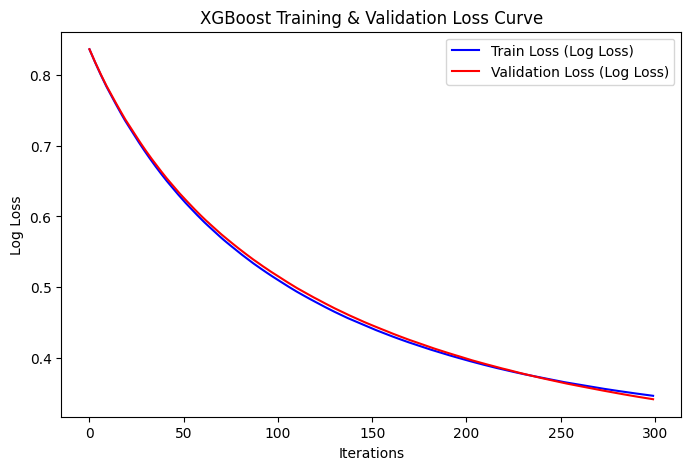

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    208044
           1       1.00      0.10      0.18     58063

    accuracy                           0.80    266107
   macro avg       0.90      0.55      0.53    266107
weighted avg       0.84      0.80      0.73    266107



In [17]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

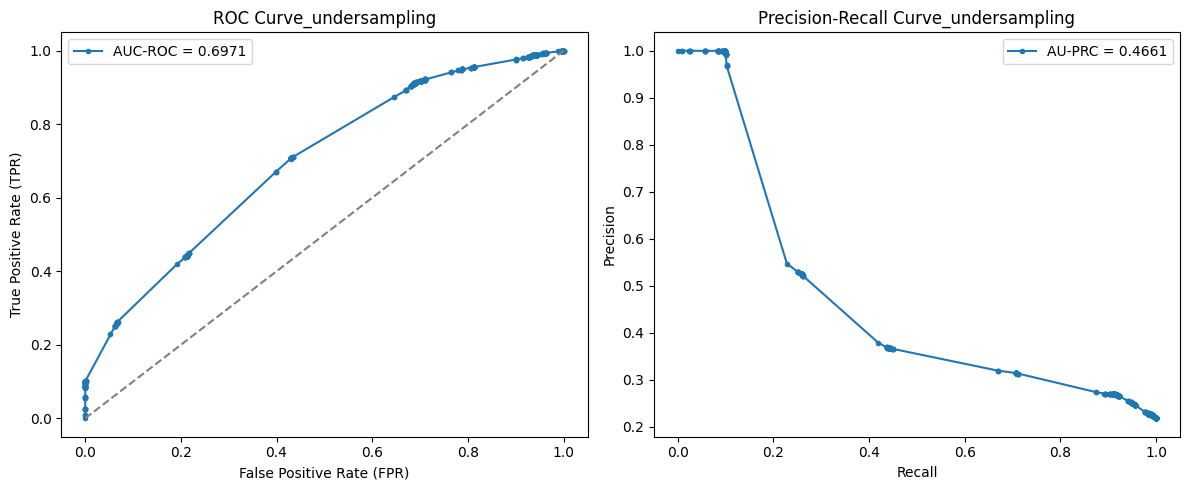

In [18]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)